# Unsupervised Learning Using K-Means Clustering on California Housing Data

### Clone the Dataset

In [ ]:
!git clone https://github.com/ageron/handson-ml2.git

Cloning into 'handson-ml2'...
remote: Enumerating objects: 3100, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3100 (delta 0), reused 1 (delta 0), pack-reused 3096 (from 1)
Receiving objects: 100% (3100/3100), 150.92 MiB | 5.51 MiB/s, done.
Resolving deltas: 100% (1905/1905), done.


### Load Data and Select Features

In [ ]:
import pandas as pd

# Load the California housing dataset and select relevant features
%cd handson-ml2/datasets/housing
housing = pd.read_csv('housing.csv')
%cd ../../../
clustering_housing = housing[['latitude', 'longitude', 'median_income']]

/content/handson-ml2/datasets/housing
/content


### Explore the data

In [ ]:
clustering_housing.describe()

,latitude,longitude,median_income
count,20640.000000,20640.000000,20640.000000
mean,35.631861,-119.569704,3.870671
std,2.135952,2.003532,1.899822
min,32.540000,-124.350000,0.499900
25%,33.930000,-121.800000,2.563400
50%,34.260000,-118.490000,3.534800
75%,37.710000,-118.010000,4.743250
max,41.950000,-114.310000,15.000100


In [ ]:
# Show missing values
clustering_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       20640 non-null  float64
 1   longitude      20640 non-null  float64
 2   median_income  20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


### Plot a figure showing the Locations

In [ ]:
import os
# Extracting jason files including the locations of the borders of California
!unzip -q "california_counties.zip" -d california_counties
# store the names of the files in california_counties folder in a list called names

names = []
for filename in os.listdir('california_counties'):
    names.append(filename)
try:
    names.remove(".ipynb_checkpoints")
except:
    pass


names_topass = ["Los Angeles.geo.json", "Santa Barbara.geo.json", "Ventura.geo.json", "Orange.geo.json"]
names_tofix = names.copy()
for name in names_topass:
    names_tofix.remove(name)

import geopandas as gpd
from shapely.geometry import Polygon
import json
import math
import os


def fix_geometry(file_path):
    try:
        with open(file_path, 'r') as reading_object:
            data = json.load(reading_object)

        # Check if the structure exists as expected
        if 'features' not in data or not data['features']:
            print(f"Invalid structure in {file_path}. 'features' not found.")
            return

        coordinates = data['features'][0]['geometry']['coordinates'][0][0]

        start, end = coordinates[0], coordinates[-1]
        if start == end:
            coordinates.pop()
        coordinates.append(start)

        # Update the geometry with fixed coordinates
        data['features'][0]['geometry']['coordinates'][0][0] = coordinates

        # Write the updated data back to the file
        with open(file_path, 'w') as writing_object:
            json.dump(data, writing_object, indent=4)

    except json.JSONDecodeError:
        print(f"Error decoding JSON in {file_path}.")
    except KeyError as e:
        print(f"Missing key {e} in {file_path}.")
    except IndexError as e:
        print(f"Index error: {e} in {file_path}.")
    except Exception as e:
        print(f"An error occurred with file {file_path}: {e}")

for name in names_tofix:
    file_path = f"california_counties/{name}"
    if os.path.exists(file_path):  # Check if file exists before attempting to fix it
        try:
            fix_geometry(file_path)  # Fix geometry
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    else:
        print(f"File {file_path} does not exist.")

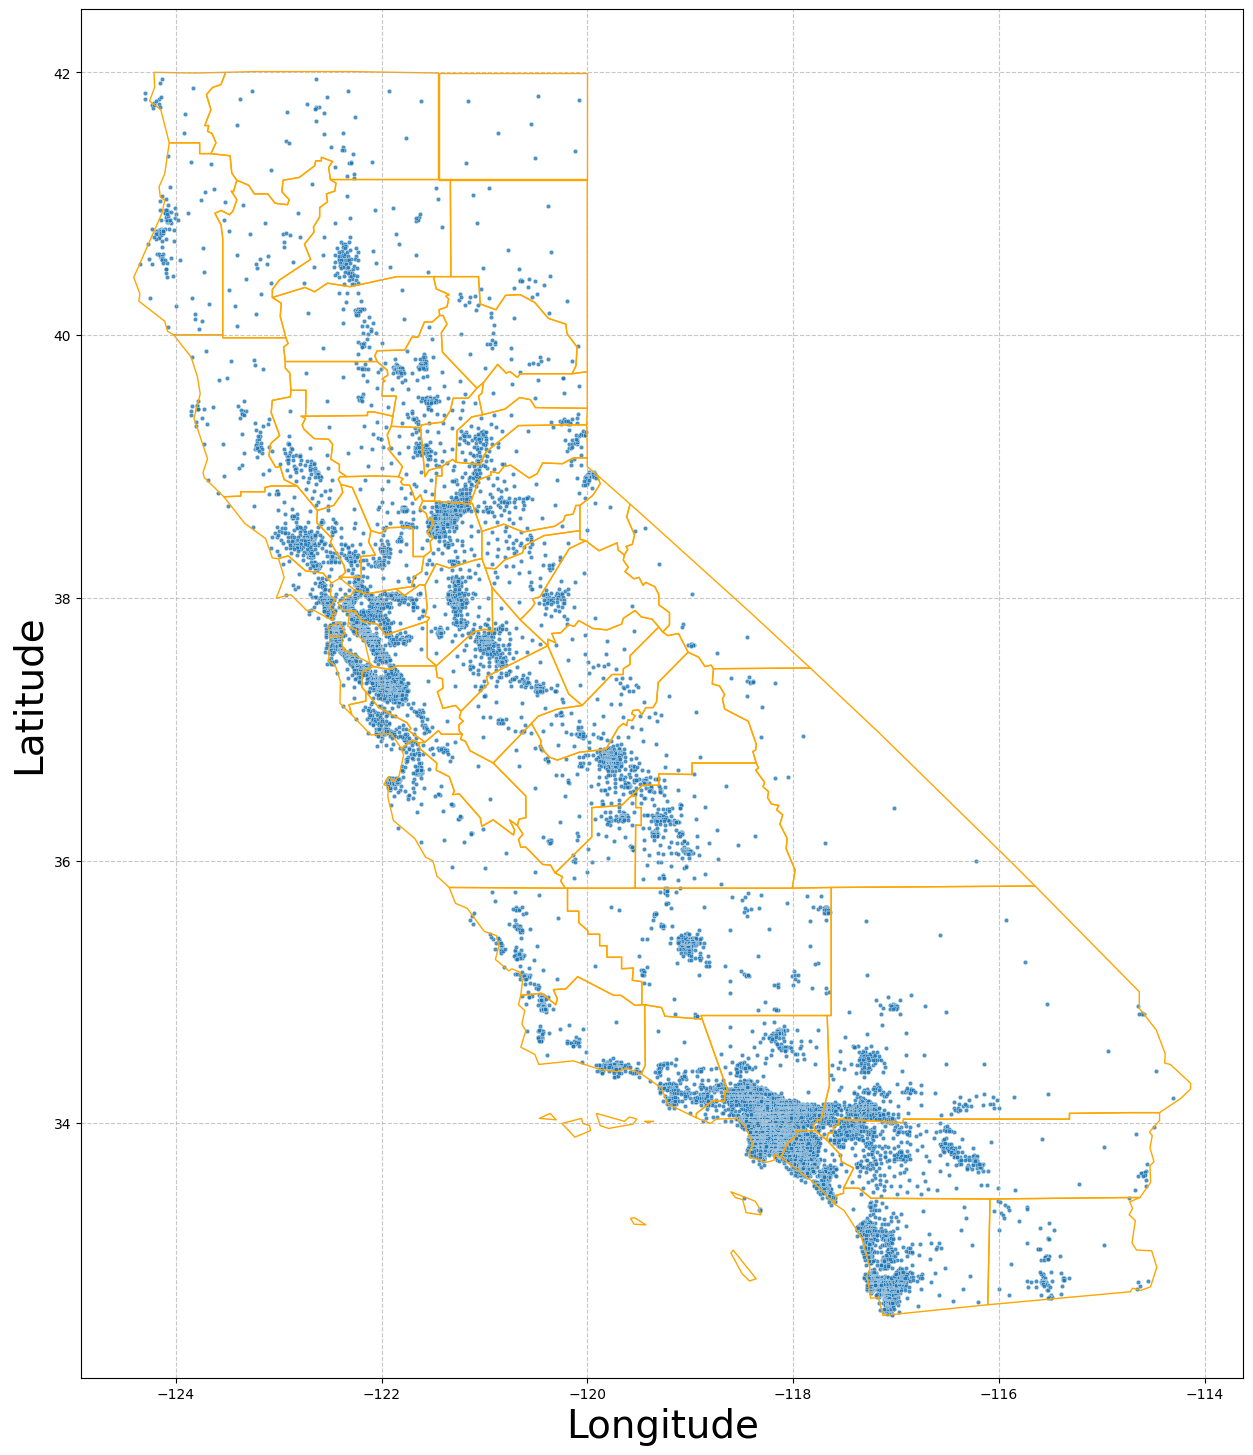

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,21))
fig = plt.gcf()
ax = plt.gca()

sns.scatterplot(data=clustering_housing, x='longitude', y='latitude', alpha=0.8, edgecolor='w', s=10)

for name in names:
    file_path = f"california_counties/{name}"
    try:
        # Get current figure and axis objects
        california_borders = gpd.read_file(file_path)
        california_borders.plot(ax=ax, color='none', edgecolor='orange')
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

plt.xlabel('Longitude', fontdict={'fontsize': 28})
plt.ylabel('Latitude', fontdict={'fontsize': 28})
plt.grid(True, linestyle='--', alpha=0.7)

def outline():
    for name in names:
        file_path = f"california_counties/{name}"
        try:
            # Get current figure and axis objects
            california_borders = gpd.read_file(file_path)
            california_borders.plot(ax=ax, color='none', edgecolor='black')
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    plt.xlabel('Longitude', fontdict={'fontsize': 28})
    plt.ylabel('Latitude', fontdict={'fontsize': 28})
    plt.grid(True, linestyle='--', alpha=0.7)


## Data Preprocessing

### Normalizing medin_income

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np


# Create log transformation pipeline
log_pipeline = make_pipeline(FunctionTransformer(np.log), StandardScaler())


### Categorizing Georgraphically

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN

class GeoTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    def fit(self, X, y=None):
        coordinates = X[['latitude', 'longitude']].copy().values
        self.dbscan.fit(coordinates)
        return self

    def transform(self, X):
        coordinates = X[['latitude', 'longitude']].copy().values
        clusters = self.dbscan.fit_predict(coordinates)
        return clusters.reshape(-1, 1)  # Reshape to a column vector



geo_transformer = GeoTransformer(eps=0.075, min_samples=6)

# geo_pipeline = make_pipeline(geo_transformer, OneHotEncoder(handle_unknown='ignore', sparse_output=False), StandardScaler())
geo_pipeline = make_pipeline(StandardScaler())

### Preprocess the data

In [ ]:
from sklearn.compose import ColumnTransformer

# Preprocess the data
preprocessing = ColumnTransformer([
    ('log', log_pipeline, ['median_income']),
    ('geo', geo_pipeline, ['latitude', 'longitude']),
])
transformed_housing = pd.DataFrame(preprocessing.fit_transform(clustering_housing))

## Training Kmeans Clustering Model

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Store the metrics for each number of clusters
scores =[]


for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    X = transformed_housing.copy()
    clusters_k = kmeans.fit_predict(X)
    clustering_housing.loc[:, f'k_clusters_{k}'] = clusters_k.copy()
    scores_k = {'k': k,
                'silhouette': silhouette_score(X, clusters_k),
                'inertia': kmeans.inertia_,
                'davies_bouldin': davies_bouldin_score(X, clusters_k),
                'calinski_harabasz': calinski_harabasz_score(X, clusters_k)
                }
    scores.append(scores_k)


# Create a DataFrame for the metrics
df_scores = pd.DataFrame(scores)
df_scores

,k,silhouette,inertia,davies_bouldin,calinski_harabasz
0,2,0.532397,26859.686922,0.742319,26939.405008
1,3,0.464047,21071.222894,0.882675,20003.675549
2,4,0.400911,13920.637893,0.905174,23718.366221
3,5,0.365300,11783.687641,0.932716,21949.313807
4,6,0.374805,10307.096137,0.920335,20665.267787
5,7,0.356922,9792.844973,1.003560,18305.218584
6,8,0.330444,8070.311964,0.945431,19667.173598
7,9,0.313199,7473.793851,1.003047,18787.185425
8,10,0.299868,6986.189519,1.033388,18024.743469
9,11,0.306772,6388.052284,0.991789,17933.275698


## Evaluate the Metrics

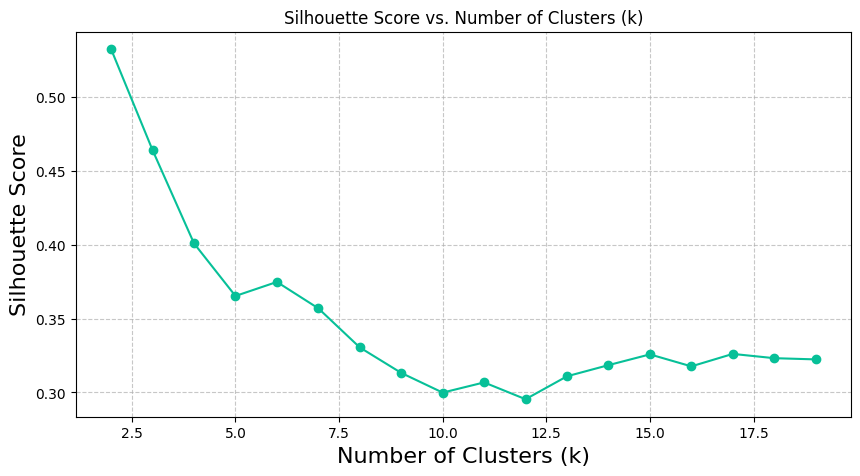

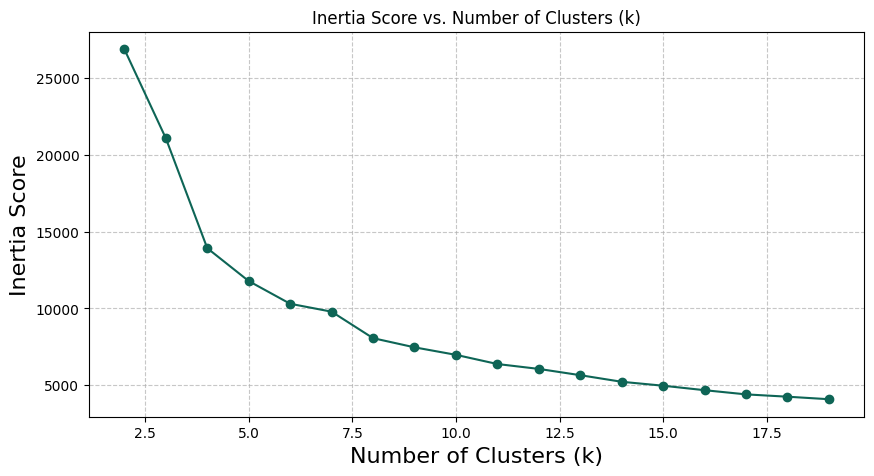

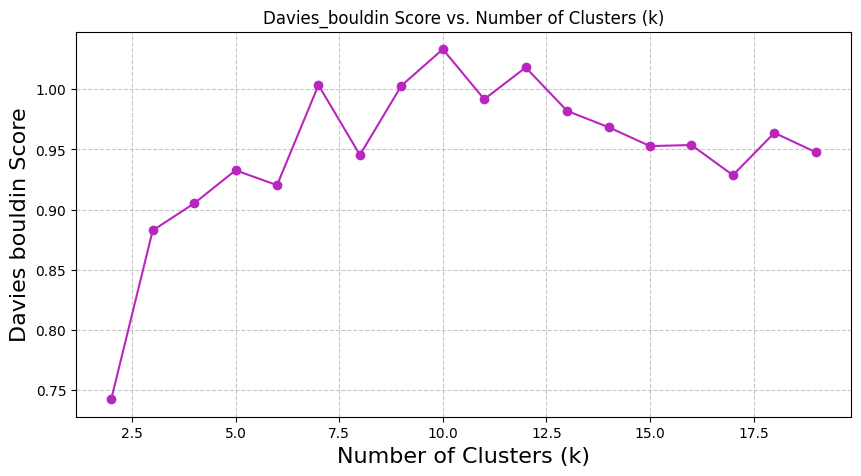

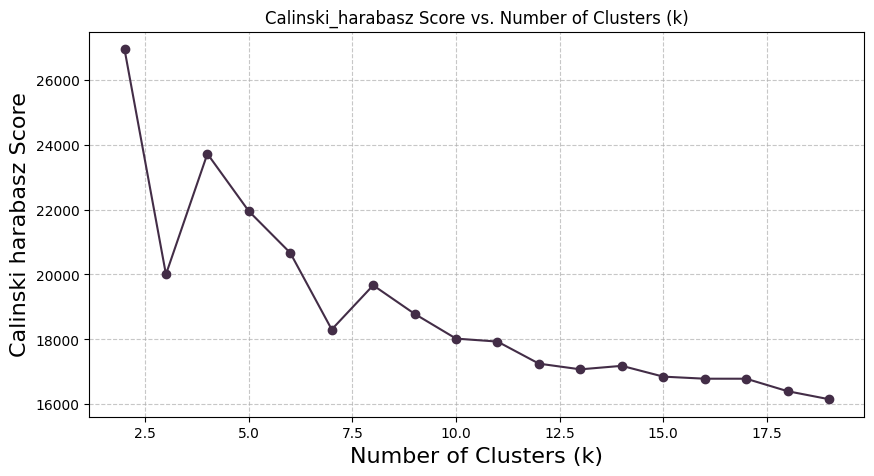

In [ ]:
import matplotlib.pyplot as plt

def plot_scores(df_scores, scores_to_plot: list):
    for score in scores_to_plot:
        plt.figure(figsize=(10, 5))
        random_color = np.random.rand(3,)
        plt.plot(df_scores['k'], df_scores[score], marker='o', linestyle='-', color=random_color, label=f'{score.capitalize()} Score')
        score_name = score.capitalize()
        scorename = score_name.replace('_', ' ')
        plt.title(f'{score_name} Score vs. Number of Clusters (k)')
        plt.xlabel('Number of Clusters (k)', fontdict={'fontsize': 16})
        plt.ylabel(f'{scorename} Score', fontdict={'fontsize': 16})
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()


plot_scores(df_scores, ['silhouette', 'inertia', 'davies_bouldin', 'calinski_harabasz'])

## Results

### Clustering Based on Optimal Silhouette Score

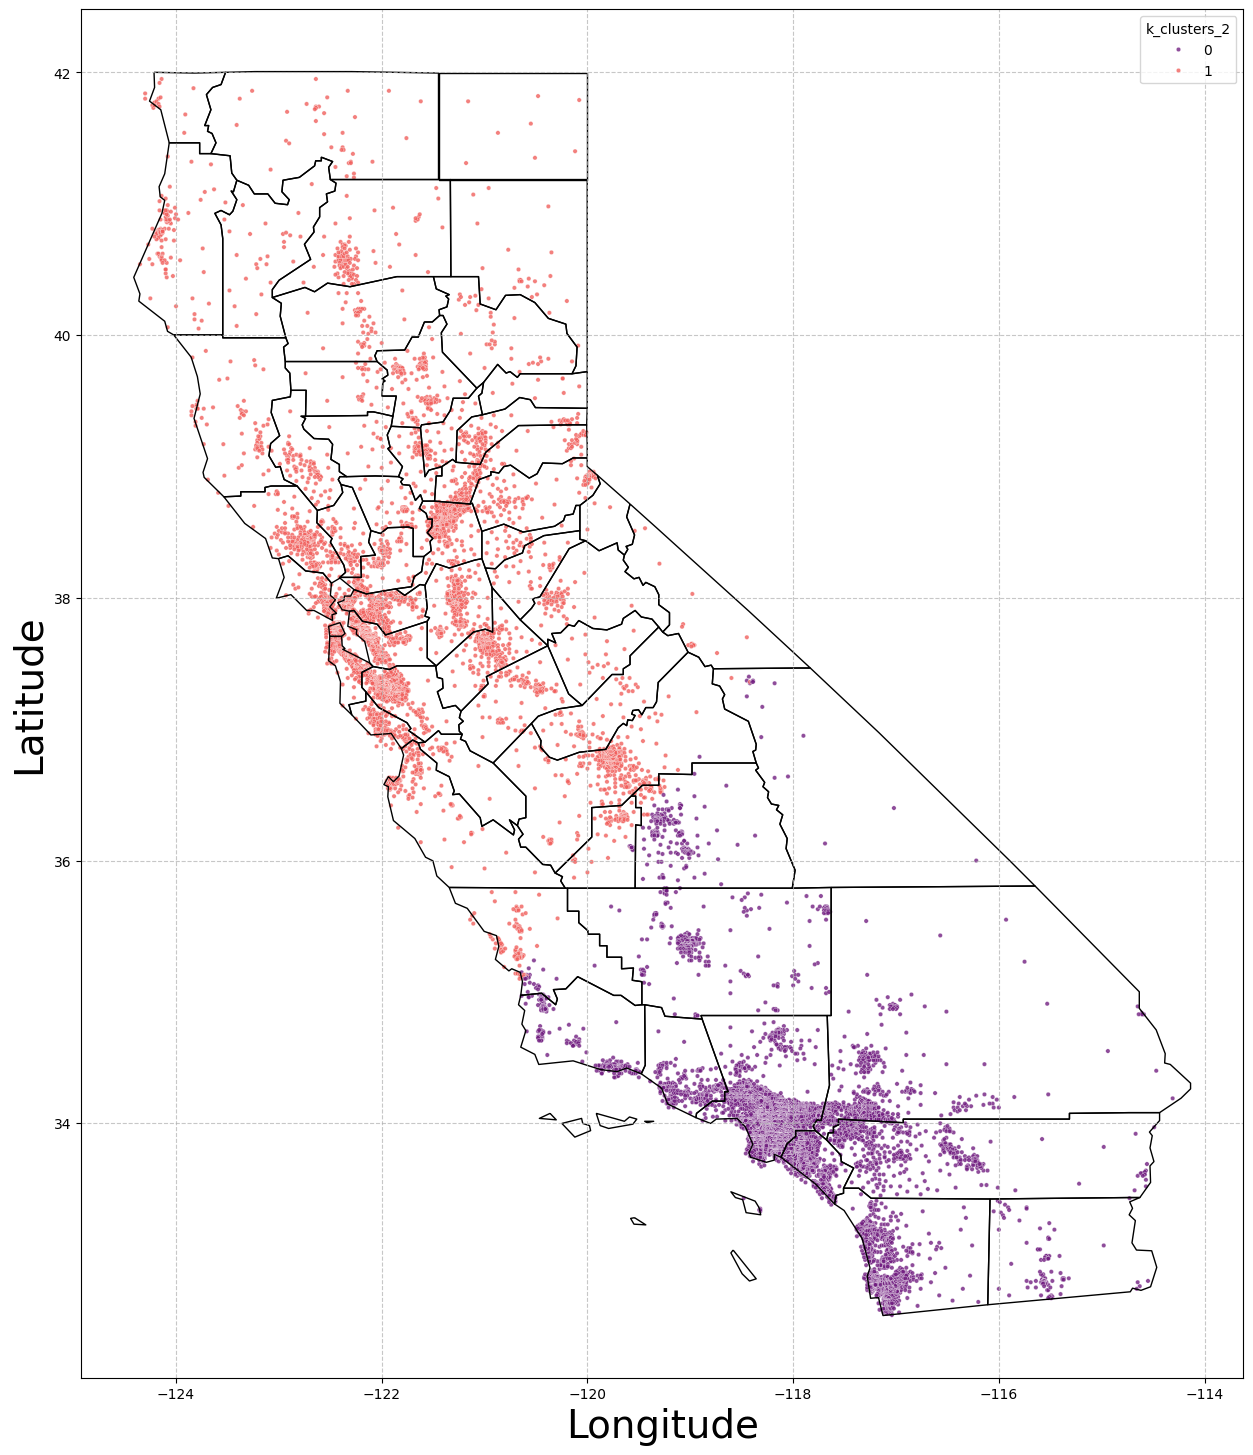

In [ ]:
# Optimal K is 2

plt.figure(figsize=(15,21))
fig = plt.gcf()
ax = plt.gca()

sns.scatterplot(data=clustering_housing, x='longitude', y='latitude', hue='k_clusters_2', palette='magma', alpha=0.8, edgecolor='w', s=10)
outline()

### Clustering Based on Elbow Method

#### Plots the inertia against the number of clusters (K) The "elbow" point, where the curve starts to bend, often indicates the optimal number of clusters

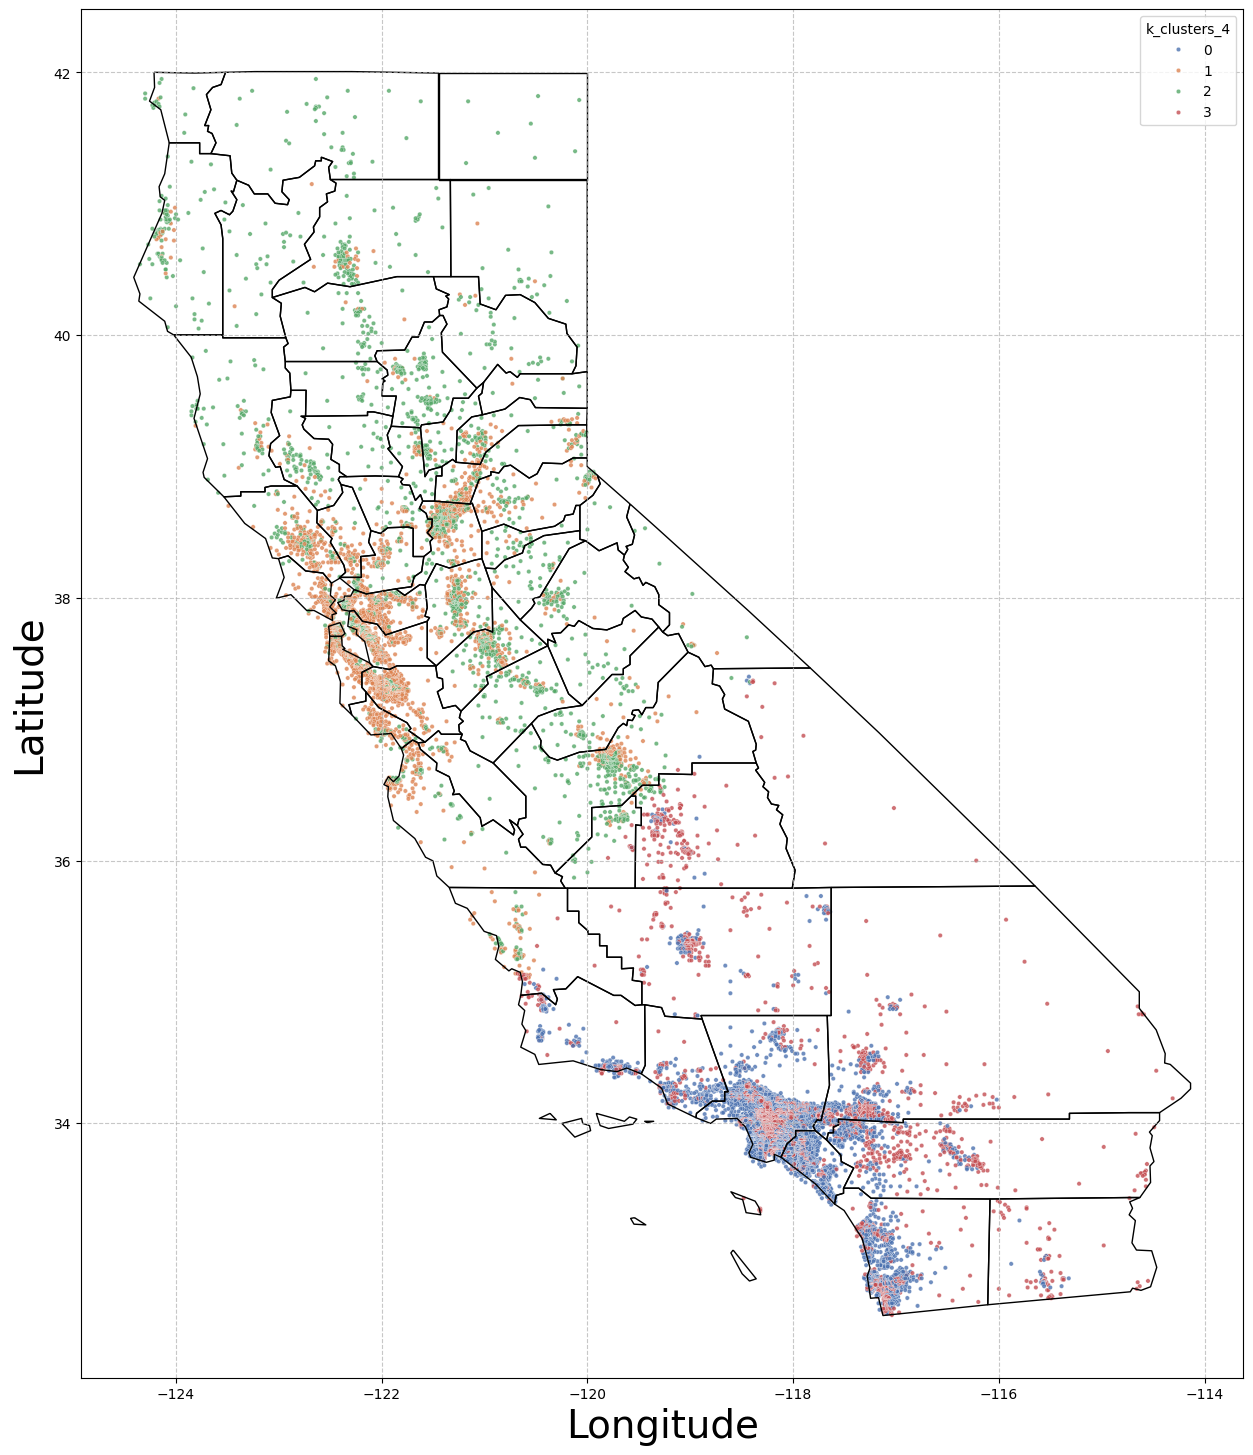

In [ ]:
#  Optimal K is 4; looking at the elbow curve

plt.figure(figsize=(15,21))
fig = plt.gcf()
ax = plt.gca()

sns.scatterplot(data=clustering_housing, x='longitude', y='latitude', hue='k_clusters_4', palette='deep', alpha=0.8, edgecolor='w', s=10)
outline()

### Clustering Based on Davis Bouldin Index

#### It measures the average similarity between each cluster and its most similar cluster. Lower values indicate better-defined clusters. Therefore, the optimal K is identified as 2, which confirms the result the Silhouette Score yielded.

### Clustering Based on Calinski-Harabasz Index

#### Ratio of the sum of between-clusters dispersion and within-cluster dispersion. Higher values indicate better-defined clusters. This metrica also is aligned with the identification of the silhouette score and Davis-Boulding Index.